In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


In [2]:
# Load the dataset
data = pd.read_csv('/content/sample_data/Online Retail.csv')


In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [5]:
# Data Preprocessing
# Drop rows with missing CustomerID values
data.dropna(subset=['CustomerID'], inplace=True)

In [8]:
# Convert 'InvoiceDate' to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


In [9]:
# Create a new feature 'TotalPrice' which is Quantity * UnitPrice
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [10]:
# Date component extraction
data['Month'] = data['InvoiceDate'].dt.month
data['Quarter'] = data['InvoiceDate'].dt.quarter
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek  # 0 = Monday, 6 = Sunday
data['Hour'] = data['InvoiceDate'].dt.hour


In [11]:
# Aggregate data at the customer level
# Calculate RFM metrics for each customer
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (number of purchases)
    'TotalPrice': 'sum'  # Monetary (total spending)
}).reset_index()

In [12]:
# Rename RFM columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [13]:
# Selecting relevant features for clustering
features = rfm[['Recency', 'Frequency', 'Monetary']]

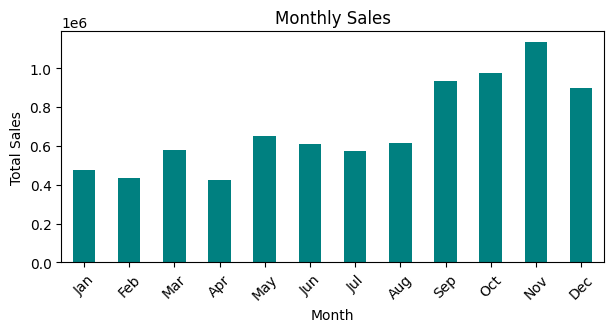

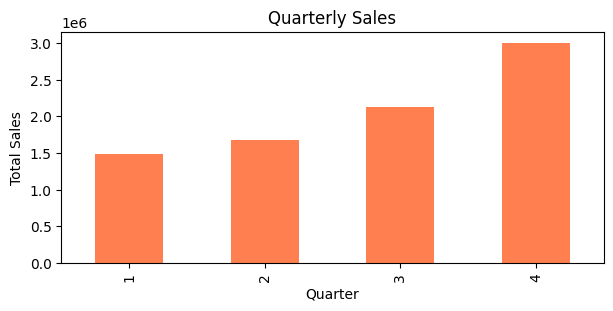

In [14]:
# Monthly and Quarterly Sales Trends:
monthly_sales = data.groupby('Month')['TotalPrice'].sum()
quarterly_sales = data.groupby('Quarter')['TotalPrice'].sum()

# Plotting Monthly Sales
plt.figure(figsize=(7, 3))
monthly_sales.plot(kind='bar', color='teal')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

# Plotting Quarterly Sales
plt.figure(figsize=(7, 3))
quarterly_sales.plot(kind='bar', color='coral')
plt.title('Quarterly Sales')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.show()


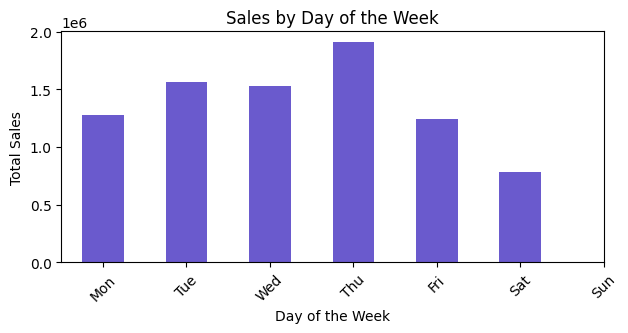

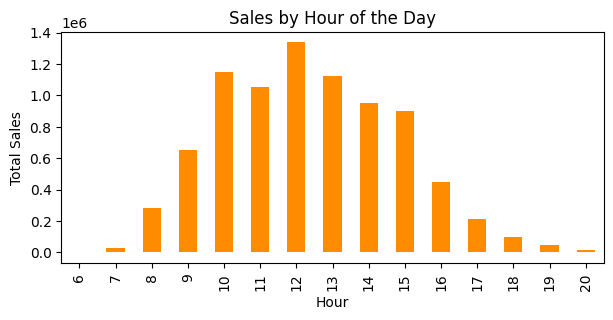

In [15]:
# Day-of-Week and Time-of-Day Analysis:
day_of_week_sales = data.groupby('DayOfWeek')['TotalPrice'].sum()
hourly_sales = data.groupby('Hour')['TotalPrice'].sum()

# Plotting Sales by Day of the Week
plt.figure(figsize=(7, 3))
day_of_week_sales.plot(kind='bar', color='slateblue')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
plt.show()

# Plotting Sales by Hour of the Day
plt.figure(figsize=(7, 3))
hourly_sales.plot(kind='bar', color='darkorange')
plt.title('Sales by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Total Sales')
plt.show()


In [16]:
# Normalize the features to ensure fair distance calculations
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [17]:
# K-Means Clustering
# Determine the optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

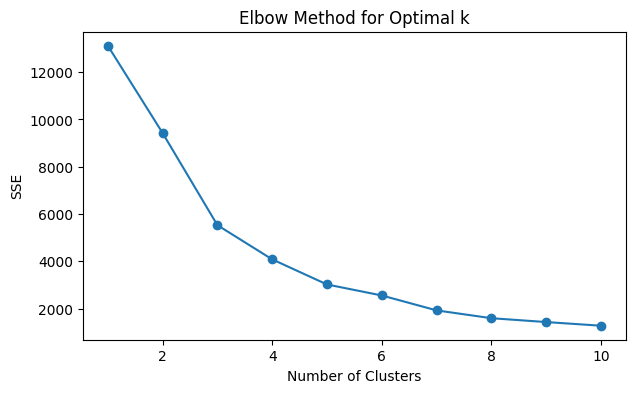

In [18]:
# Plot the SSE to visualize the Elbow
plt.figure(figsize=(7, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

In [19]:
# Choose the optimal number of clusters based on the Elbow plot
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(scaled_features)

# Display the first few rows to verify the cluster assignments
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster']].head())


   CustomerID  Recency  Frequency  Monetary  Cluster
0     12346.0      326          2      0.00        1
1     12347.0        2          7   4310.00        0
2     12348.0       75          4   1797.24        0
3     12349.0       19          1   1757.55        0
4     12350.0      310          1    334.40        1


In [20]:
# Display Cluster Centroids and disply Output
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=['Recency', 'Frequency', 'Monetary'])
centroids_df.index = [f'Cluster {i}' for i in range(len(centroids))]

print("K-Means Cluster Centroids:")
print(centroids_df)


K-Means Cluster Centroids:
            Recency  Frequency  Monetary
Cluster 0 -0.514395   0.055487 -0.009428
Cluster 1  1.535311  -0.346676 -0.175377
Cluster 2 -0.853169   8.759567  9.726631


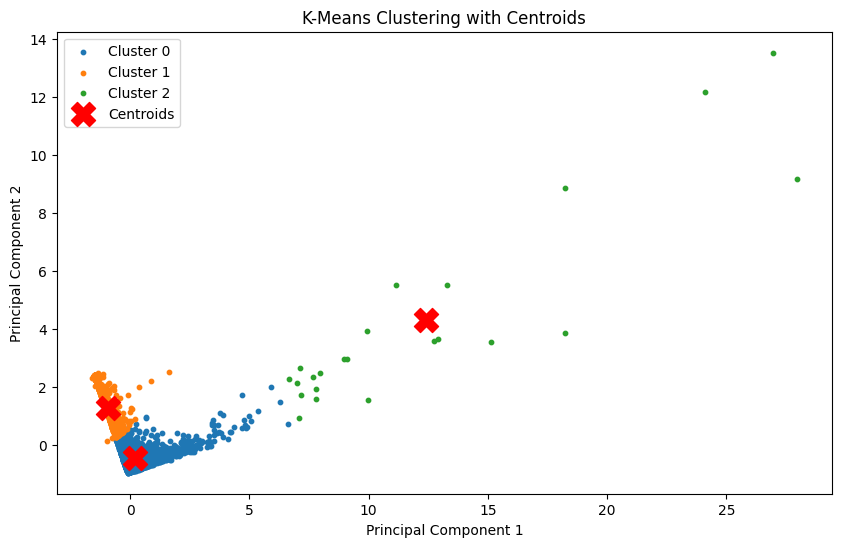

In [21]:
# Visualize Clusters using 2D PCA Plot
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
reduced_centroids = pca.transform(centroids)

plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    cluster_points = reduced_features[rfm['Cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {i}')

plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering with Centroids')
plt.legend()
plt.show()


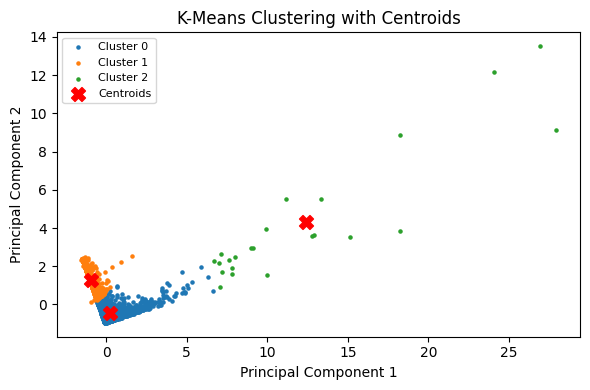

In [22]:
# Visualize Clusters using 2D PCA Plot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
reduced_centroids = pca.transform(centroids)

# Adjusted figure size and scatter point size
plt.figure(figsize=(6, 4))  # Smaller figure size for better legibility
for i in range(optimal_k):
    cluster_points = reduced_features[rfm['Cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=5, label=f'Cluster {i}')  # Smaller points for clusters

plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], s=100, c='red', marker='X', label='Centroids')  # Reduced size for centroids
plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
plt.title('K-Means Clustering with Centroids', fontsize=12)
plt.legend(fontsize=8)
plt.tight_layout()  # Automatically adjust spacing for better visualization
plt.show()


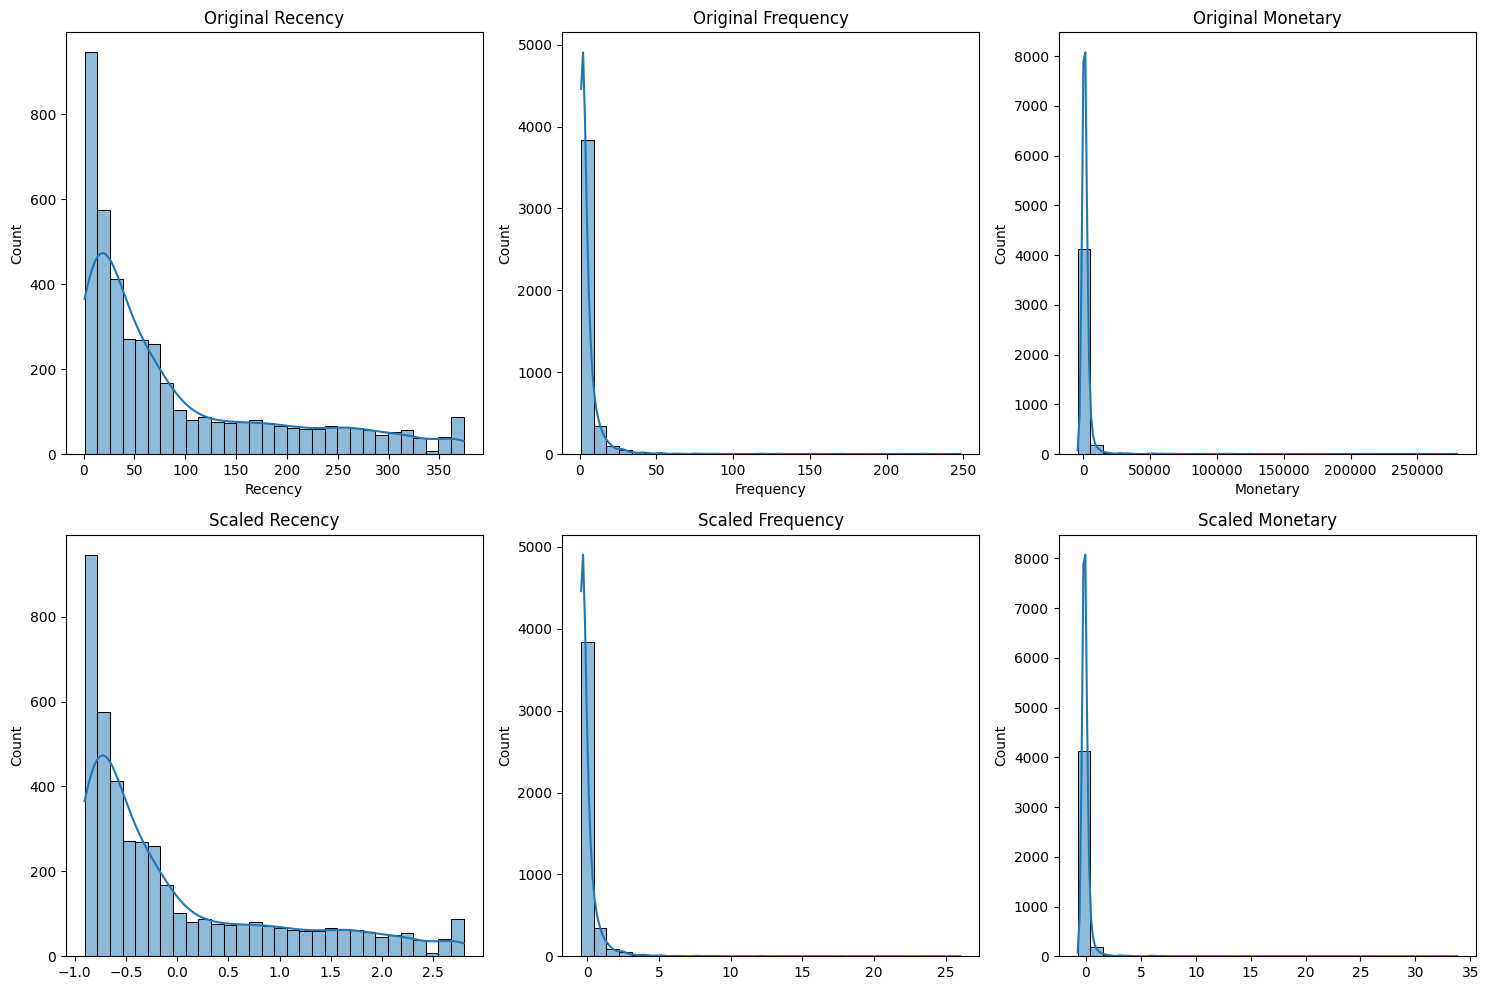

In [51]:
# Compare original and scaled distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(rfm['Recency'], ax=axes[0, 0], kde=True, bins=30).set_title("Original Recency")
sns.histplot(rfm['Frequency'], ax=axes[0, 1], kde=True, bins=30).set_title("Original Frequency")
sns.histplot(rfm['Monetary'], ax=axes[0, 2], kde=True, bins=30).set_title("Original Monetary")

sns.histplot(scaled_features[:, 0], ax=axes[1, 0], kde=True, bins=30).set_title("Scaled Recency")
sns.histplot(scaled_features[:, 1], ax=axes[1, 1], kde=True, bins=30).set_title("Scaled Frequency")
sns.histplot(scaled_features[:, 2], ax=axes[1, 2], kde=True, bins=30).set_title("Scaled Monetary")
plt.tight_layout()
plt.show()


In [52]:
# Calculate IQR for each feature
Q1 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.25)
Q3 = rfm[['Recency', 'Frequency', 'Monetary']].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify potential outliers
potential_outliers = rfm[
    (rfm['Recency'] < lower_bound['Recency']) | (rfm['Recency'] > upper_bound['Recency']) |
    (rfm['Frequency'] < lower_bound['Frequency']) | (rfm['Frequency'] > upper_bound['Frequency']) |
    (rfm['Monetary'] < lower_bound['Monetary']) | (rfm['Monetary'] > upper_bound['Monetary'])
]

print(f"Number of potential outliers: {potential_outliers.shape[0]}")
print(potential_outliers.head())


Number of potential outliers: 692
    CustomerID  Recency  Frequency  Monetary  Cluster  Hierarchical_Cluster
1      12347.0        2          7   4310.00        0                     1
10     12357.0       33          1   6207.67        0                     1
12     12359.0        8          6   6245.53        0                     1
15     12362.0        3         13   5154.58        0                     1
27     12378.0      130          1   4008.62        0                     1


In [53]:
# Remove outliers
rfm_cleaned = rfm.drop(index=potential_outliers.index)
scaled_features_cleaned = scaled_features[np.isin(rfm.index, rfm_cleaned.index)]

print(f"RFM cleaned size: {rfm_cleaned.shape}")


RFM cleaned size: (3680, 6)


In [54]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_features_no_outliers = scaler.fit_transform(rfm_cleaned[['Recency', 'Frequency', 'Monetary']])
print("Scaled features after outlier removal:")
print(scaled_features_no_outliers[:5])


Scaled features after outlier removal:
[[ 2.19472617  0.         -0.65851727]
 [ 0.15821501  0.66666667  1.41164816]
 [-0.29614604 -0.33333333  1.36593092]
 [ 2.06490872 -0.33333333 -0.27333593]
 [-0.15821501  3.          1.12157574]]


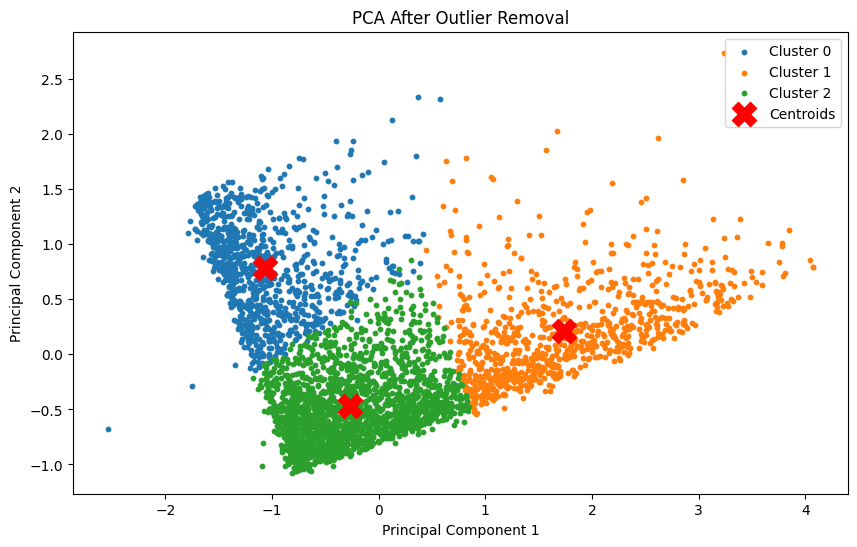

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Re-run PCA
pca = PCA(n_components=2)
reduced_features_no_outliers = pca.fit_transform(scaled_features_no_outliers)

# Run KMeans again
from sklearn.cluster import KMeans

optimal_k = 3  # Replace with your determined optimal value
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_cleaned['Cluster'] = kmeans.fit_predict(scaled_features_no_outliers)

reduced_centroids = pca.transform(kmeans.cluster_centers_)

# Plot PCA
plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    cluster_points = reduced_features_no_outliers[rfm_cleaned['Cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {i}')
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA After Outlier Removal')
plt.legend()
plt.show()


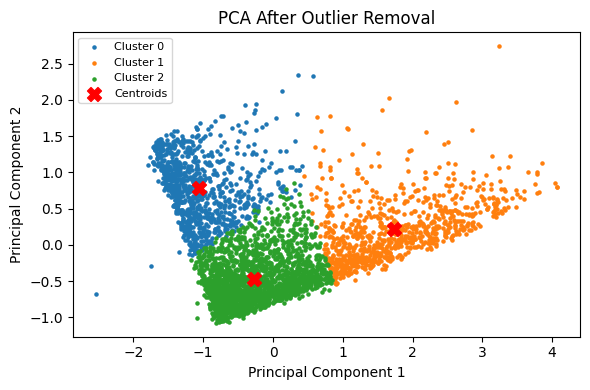

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Re-run PCA
pca = PCA(n_components=2)
reduced_features_no_outliers = pca.fit_transform(scaled_features_no_outliers)

# Run KMeans again
optimal_k = 3  # Replace with your determined optimal value
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_cleaned['Cluster'] = kmeans.fit_predict(scaled_features_no_outliers)

reduced_centroids = pca.transform(kmeans.cluster_centers_)

# Adjusted figure size and scatter point size
plt.figure(figsize=(6, 4))  # Smaller figure size for better legibility
for i in range(optimal_k):
    cluster_points = reduced_features_no_outliers[rfm_cleaned['Cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=5, label=f'Cluster {i}')  # Smaller points for clusters

plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], s=100, c='red', marker='X', label='Centroids')  # Reduced size for centroids
plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
plt.title('PCA After Outlier Removal', fontsize=12)
plt.legend(fontsize=8)
plt.tight_layout()  # Automatically adjust spacing for better visualization
plt.show()


      Recency  Frequency  Monetary
PC1 -0.360646   0.619169  0.697542
PC2  0.926185   0.149478  0.346177


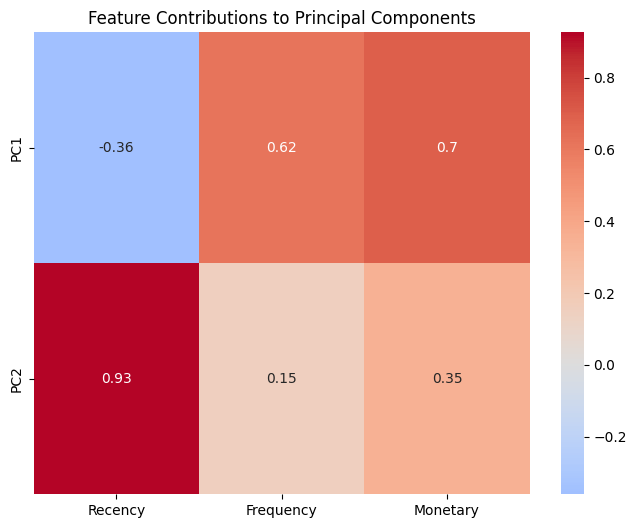

In [57]:
import pandas as pd
import seaborn as sns

# PCA components influence
components = pd.DataFrame(pca.components_, columns=['Recency', 'Frequency', 'Monetary'], index=['PC1', 'PC2'])
print(components)

# Visualize feature contributions
plt.figure(figsize=(8, 6))
sns.heatmap(components, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Contributions to Principal Components")
plt.show()


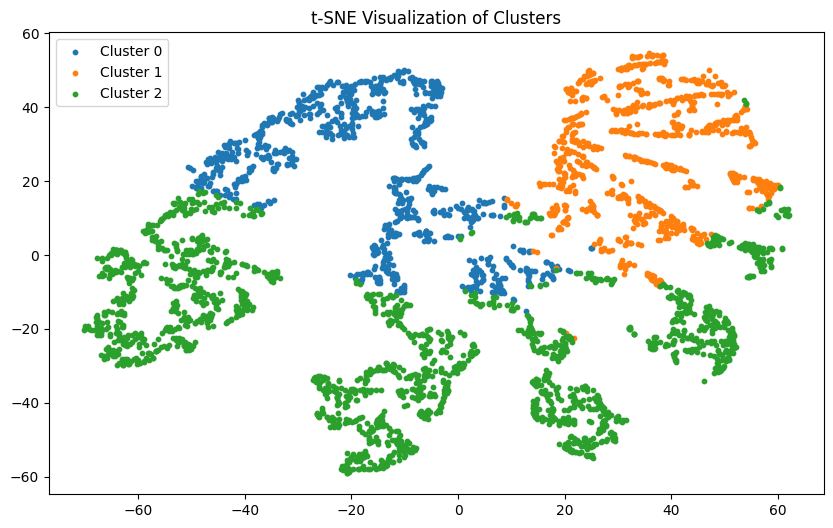

In [58]:
from sklearn.manifold import TSNE

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_features_tsne = tsne.fit_transform(scaled_features_no_outliers)

plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    cluster_points = reduced_features_tsne[rfm_cleaned['Cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {i}')
plt.title('t-SNE Visualization of Clusters')
plt.legend()
plt.show()


In [59]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate silhouette score for K-Means clusters
silhouette_avg = silhouette_score(scaled_features_no_outliers, kmeans.labels_)
print(f"Silhouette Score After Outlier Removal: {silhouette_avg}")

# Calculate Davies-Bouldin index
db_index = davies_bouldin_score(scaled_features_no_outliers, kmeans.labels_)
print(f"Davies-Bouldin Index After Outlier Removal: {db_index}")


Silhouette Score After Outlier Removal: 0.4349191259500343
Davies-Bouldin Index After Outlier Removal: 0.8102404621659507


In [61]:
# Analyze extreme Recency and Monetary values in the RFM dataset
edge_points = rfm_cleaned[
    (rfm_cleaned['Recency'] > rfm_cleaned['Recency'].quantile(0.95)) |
    (rfm_cleaned['Monetary'] > rfm_cleaned['Monetary'].quantile(0.95))
]

print(f"Number of Edge Points (Extreme Customers): {len(edge_points)}")
print(edge_points[['CustomerID', 'Recency', 'Frequency', 'Monetary']])

# Save the edge points for deeper business insights
edge_points.to_csv("edge_customers.csv", index=False)


Number of Edge Points (Extreme Customers): 367
      CustomerID  Recency  Frequency  Monetary
0        12346.0      326          2      0.00
4        12350.0      310          1    334.40
9        12356.0       23          3   2811.43
13       12360.0       52          3   2662.06
14       12361.0      287          1    189.90
...          ...      ...        ...       ...
4331     18230.0        9         10   2716.60
4334     18233.0      326          1    440.00
4346     18250.0      301          2    342.92
4353     18260.0      173          8   2595.00
4361     18272.0        3          7   3064.78

[367 rows x 4 columns]


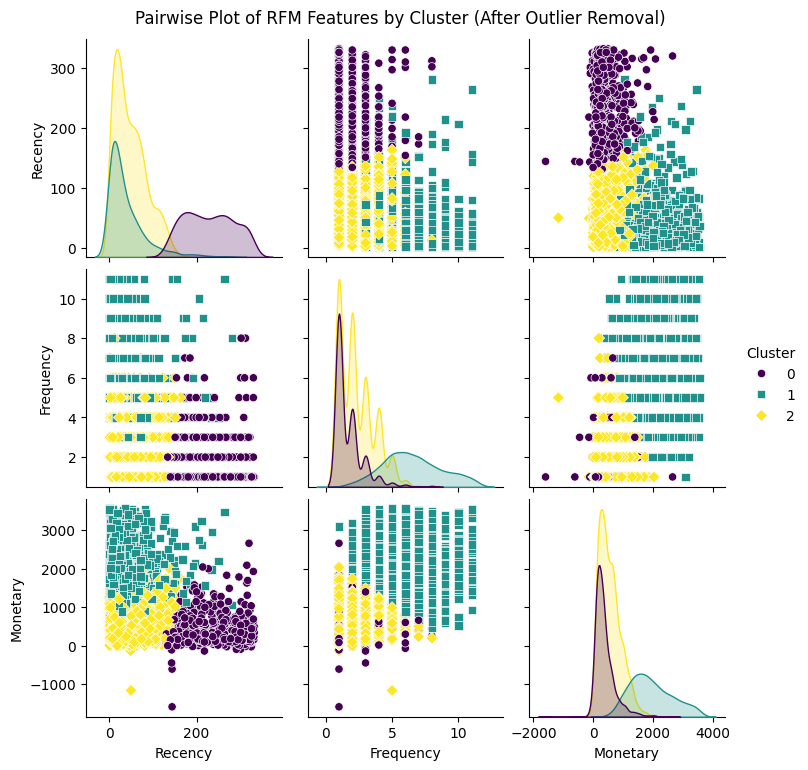

In [62]:
import seaborn as sns

# Pairplot for visualizing Recency, Frequency, Monetary for clusters
sns.pairplot(rfm_cleaned, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='viridis', diag_kind='kde', markers=["o", "s", "D"])
plt.suptitle("Pairwise Plot of RFM Features by Cluster (After Outlier Removal)", y=1.02)
plt.show()


In [63]:
# Summary statistics for each cluster
cluster_summary = rfm_cleaned.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std', 'min', 'max'],
    'Frequency': ['mean', 'median', 'std', 'min', 'max'],
    'Monetary': ['mean', 'median', 'std', 'min', 'max']
}).reset_index()

print("Cluster Summary After Outlier Removal:")
print(cluster_summary)


Cluster Summary After Outlier Removal:
  Cluster     Recency                             Frequency                   \
                 mean median        std  min  max      mean median       std   
0       0  229.181917  227.0  55.419611  127  332  1.706972    1.0  1.078275   
1       1   38.956674   25.0  43.115176    1  281  6.507026    6.0  2.187425   
2       2   48.519916   40.0  36.126985    1  163  2.308700    2.0  1.282608   

              Monetary                                         
  min max         mean   median         std      min      max  
0   1   8   372.458573   297.89  335.661290 -1592.49  2661.24  
1   1  11  1931.274369  1817.07  699.970288   452.63  3563.85  
2   1   8   550.613513   482.24  363.036986 -1165.30  2062.06  


Feature Contributions to Principal Components (After Outlier Removal):
      Recency  Frequency  Monetary
PC1 -0.360646   0.619169  0.697542
PC2  0.926185   0.149478  0.346177


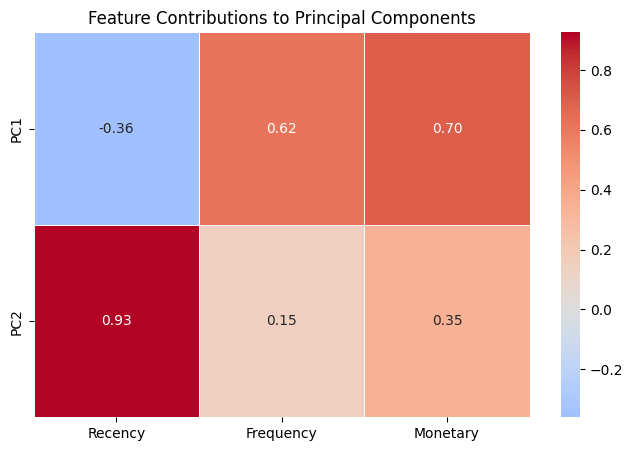

In [64]:
# Contribution of features to PCA components (already calculated)
contributions = pd.DataFrame(pca.components_, columns=['Recency', 'Frequency', 'Monetary'], index=['PC1', 'PC2'])
print("Feature Contributions to Principal Components (After Outlier Removal):")
print(contributions)

# Heatmap for contributions
plt.figure(figsize=(8, 5))
sns.heatmap(contributions, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt='.2f')
plt.title("Feature Contributions to Principal Components")
plt.show()


In [65]:
# Cohesion (Intra-cluster distance)
cohesion = []
for i in range(optimal_k):
    cluster_points = scaled_features[rfm['Cluster'] == i]
    centroid = centroids[i].reshape(1, -1)
    distances = pairwise_distances(cluster_points, centroid)
    cohesion.append(np.mean(distances))

avg_cohesion = np.mean(cohesion)
print("Average Intra-Cluster Distance (Cohesion):", avg_cohesion)

Average Intra-Cluster Distance (Cohesion): 3.3465686050415964


In [66]:
# Separation (Inter-cluster distance)
separation = []
for i in range(optimal_k):
    for j in range(i + 1, optimal_k):
        separation_dist = np.linalg.norm(centroids[i] - centroids[j])
        separation.append(separation_dist)

avg_separation = np.mean(separation)
print("Average Inter-Cluster Distance (Separation):", avg_separation)

Average Inter-Cluster Distance (Separation): 9.60744594867847


In [67]:
# Quality Ratio
quality_ratio = avg_separation / avg_cohesion
print("Quality Ratio (Separation / Cohesion):", quality_ratio)

Quality Ratio (Separation / Cohesion): 2.870834900621753


In [68]:
# Cluster Analysis - Summary Statistics for Each Cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'std', 'min', 'max', 'median'],
    'Frequency': ['mean', 'std', 'min', 'max', 'median'],
    'Monetary': ['mean', 'std', 'min', 'max', 'median']
}).reset_index()

In [69]:
# Rename columns for clarity
cluster_summary.columns = ['Cluster', 'Avg_Recency', 'Std_Recency', 'Min_Recency', 'Max_Recency', 'Median_Recency',
                           'Avg_Frequency', 'Std_Frequency', 'Min_Frequency', 'Max_Frequency', 'Median_Frequency',
                           'Avg_Monetary', 'Std_Monetary', 'Min_Monetary', 'Max_Monetary', 'Median_Monetary']
print("Detailed Cluster Profiles:")
print(cluster_summary)

Detailed Cluster Profiles:
   Cluster  Avg_Recency  Std_Recency  Min_Recency  Max_Recency  \
0        0    40.091245    35.093975            1          163   
1        1   246.365611    68.262005          137          374   
2        2     6.086957     9.105009            1           39   

   Median_Recency  Avg_Frequency  Std_Frequency  Min_Frequency  Max_Frequency  \
0            29.0       5.595561       6.508690              1             86   
1           241.0       1.846154       1.746592              1             35   
2             3.0      86.869565      58.066032             26            248   

   Median_Frequency  Avg_Monetary  Std_Monetary  Min_Monetary  Max_Monetary  \
0               4.0   1821.839757   3111.260635      -1165.30      51823.72   
1               1.0    459.541105    910.791675      -4287.63      21535.90   
2              66.0  81835.857391  71893.199439      10930.26     279489.02   

   Median_Monetary  
0          897.045  
1          298.000  
2  

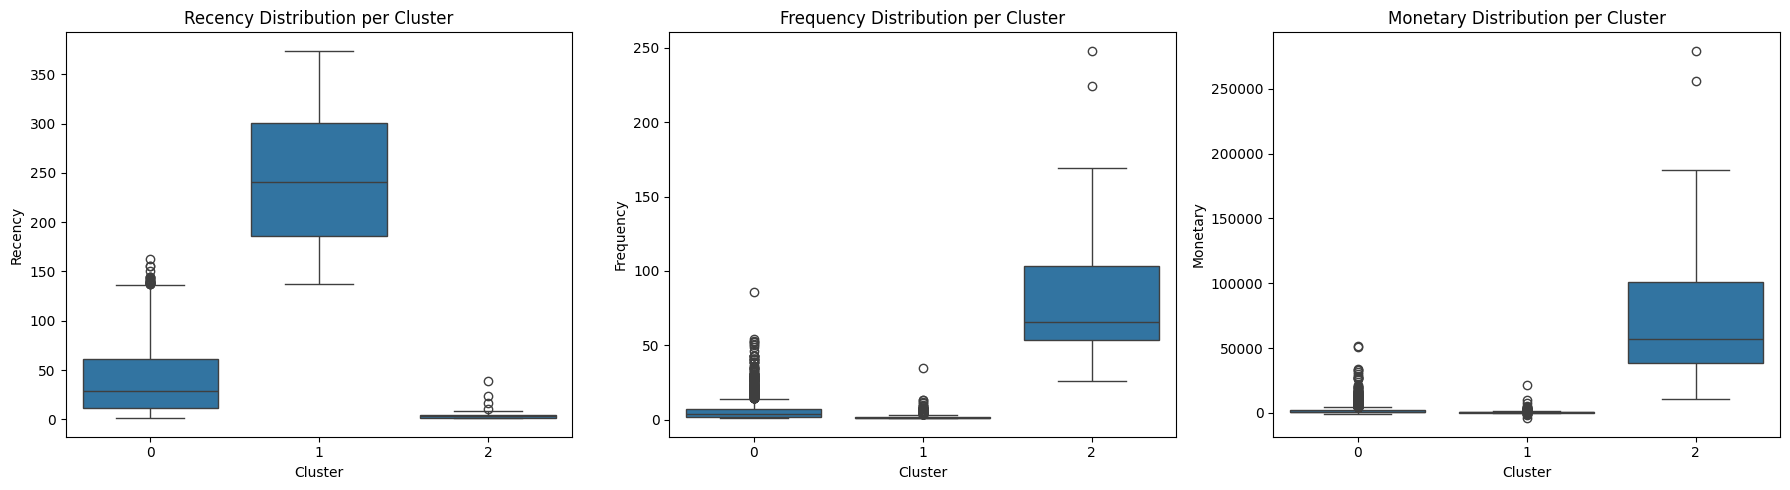

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a single row of boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Recency Distribution per Cluster
sns.boxplot(ax=axes[0], x='Cluster', y='Recency', data=rfm)
axes[0].set_title('Recency Distribution per Cluster')

# Frequency Distribution per Cluster
sns.boxplot(ax=axes[1], x='Cluster', y='Frequency', data=rfm)
axes[1].set_title('Frequency Distribution per Cluster')

# Monetary Distribution per Cluster
sns.boxplot(ax=axes[2], x='Cluster', y='Monetary', data=rfm)
axes[2].set_title('Monetary Distribution per Cluster')

# Adjust layout
plt.tight_layout()
plt.show()


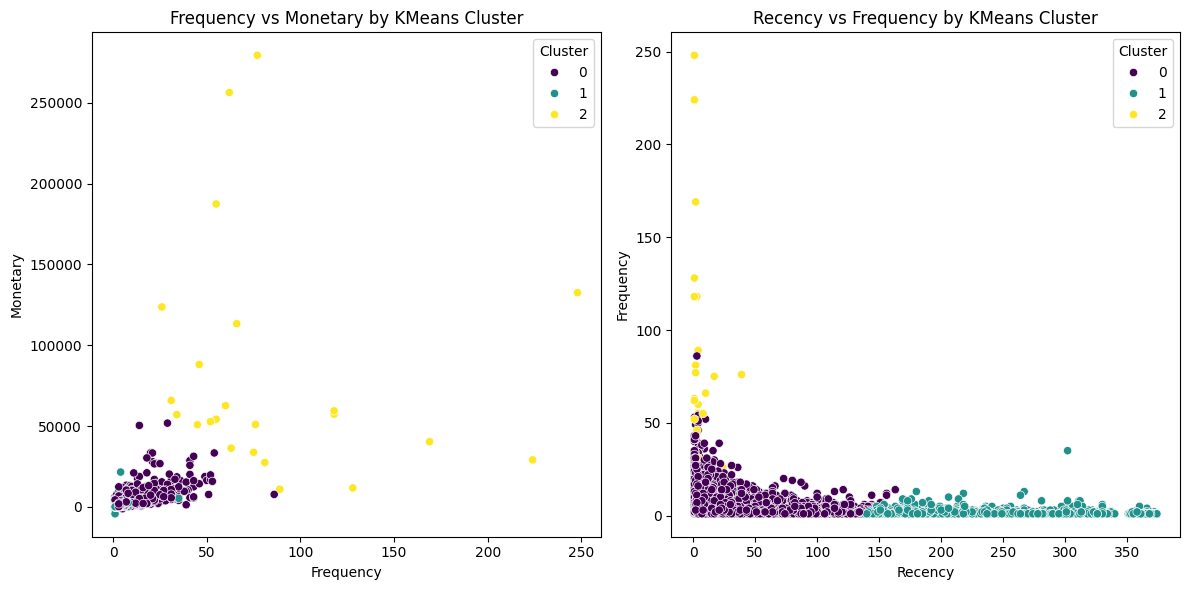

In [71]:
# Scatter Plot for Frequency vs Monetary
plt.figure(figsize=(12, 6))

# Plotting Frequency vs Monetary by Cluster
plt.subplot(1, 2, 1)
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title('Frequency vs Monetary by KMeans Cluster')
plt.xlabel('Frequency')
plt.ylabel('Monetary')

# Scatter Plot for Recency vs Frequency by Cluster
plt.subplot(1, 2, 2)
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm, palette='viridis')
plt.title('Recency vs Frequency by KMeans Cluster')
plt.xlabel('Recency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


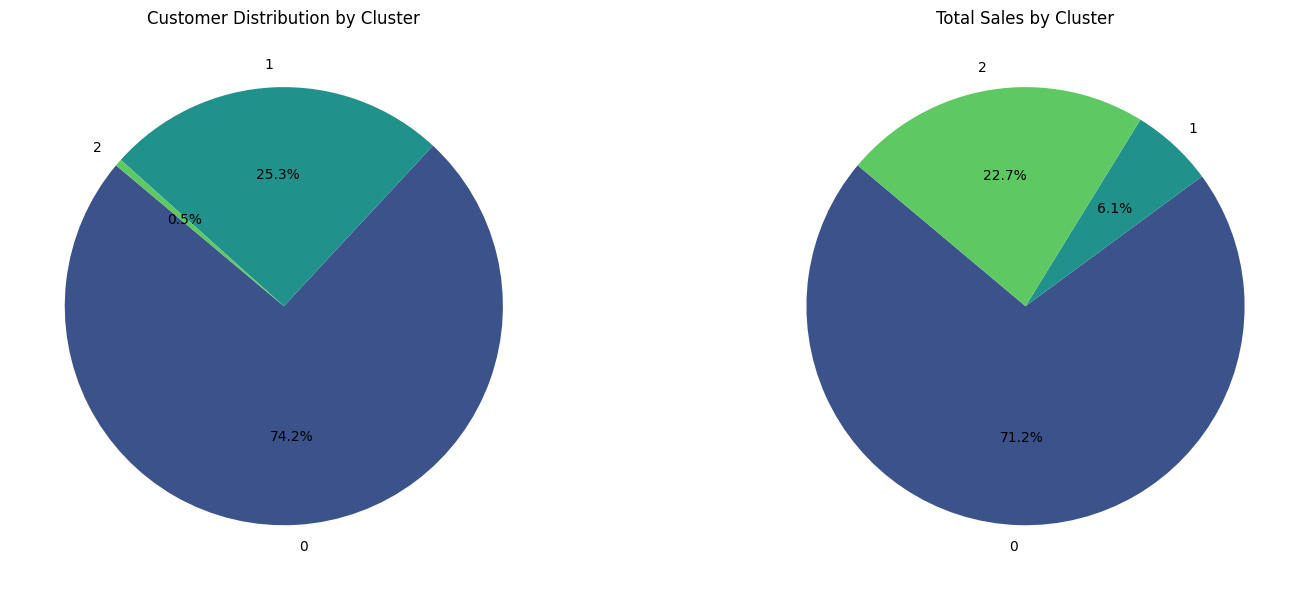

In [72]:
# Calculate the total sales (monetary value) for each cluster
cluster_sales = rfm.groupby('Cluster')['Monetary'].sum()

# Get the counts of customers in each cluster
cluster_counts = rfm['Cluster'].value_counts()

# Set up a figure with two pie charts: one for cluster sizes and one for total sales
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart for customer distribution by cluster
axes[0].pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(cluster_counts)))
axes[0].set_title("Customer Distribution by Cluster")

# Pie chart for total sales by cluster
axes[1].pie(cluster_sales, labels=cluster_sales.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(cluster_sales)))
axes[1].set_title("Total Sales by Cluster")

plt.tight_layout()
plt.show()


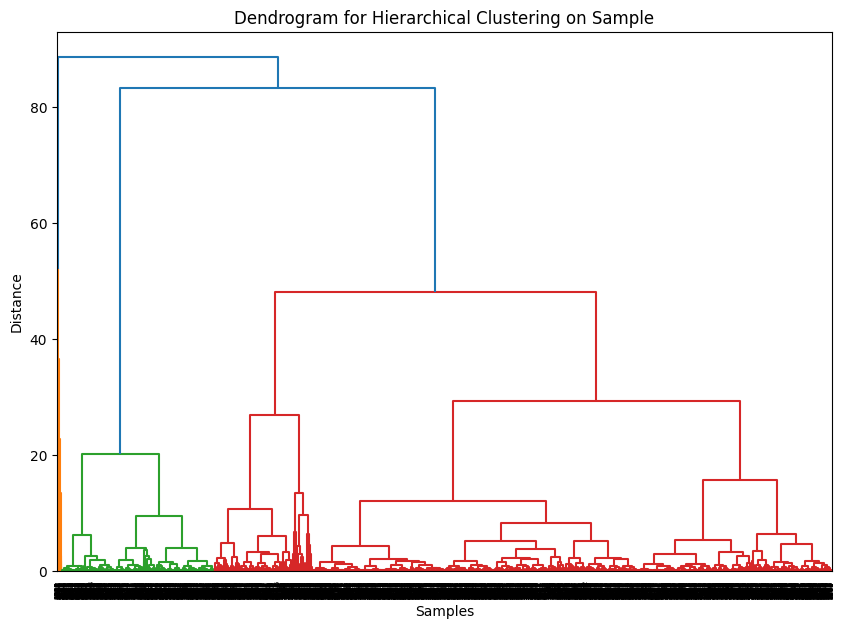

In [44]:
# Generate a dendrogram for hierarchical clustering
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Hierarchical Clustering on Sample')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

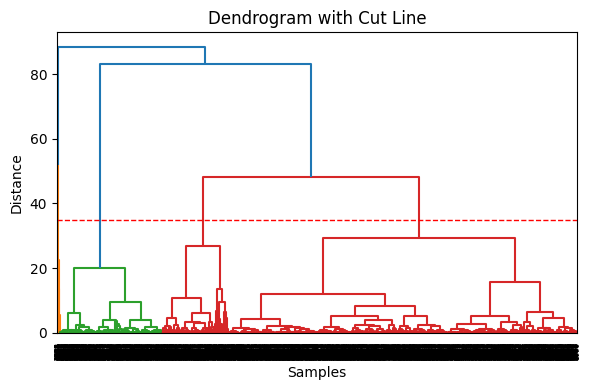

In [45]:
# Generate the dendrogram with a horizontal cut line
plt.figure(figsize=(6, 4))  # Smaller figure size for better legibility
dendrogram(linked)
plt.axhline(y=35, color='r', linestyle='--', linewidth=1)  # Adjusted line width for clarity
plt.title('Dendrogram with Cut Line', fontsize=12)  # Shortened title for simplicity
plt.xlabel('Samples', fontsize=10)
plt.ylabel('Distance', fontsize=10)
plt.tight_layout()  # Automatically adjust spacing for better visualization
plt.show()



In [46]:
# Apply Agglomerative Clustering to limit to 3 clusters
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
rfm['Hierarchical_Cluster'] = hierarchical_clustering.fit_predict(scaled_features)


In [47]:
# Display the first few rows to verify the cluster assignments
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Hierarchical_Cluster']].head())


   CustomerID  Recency  Frequency  Monetary  Hierarchical_Cluster
0     12346.0      326          2      0.00                     2
1     12347.0        2          7   4310.00                     1
2     12348.0       75          4   1797.24                     1
3     12349.0       19          1   1757.55                     1
4     12350.0      310          1    334.40                     2


In [48]:
# Calculate silhouette score for quality assessment
silhouette_avg = silhouette_score(scaled_features, rfm['Hierarchical_Cluster'])
print(f"Average Silhouette Score for Hierarchical Clustering: {silhouette_avg}")


Average Silhouette Score for Hierarchical Clustering: 0.5883136275639812


In [49]:
# Summarize the hierarchical clusters
hierarchical_summary = rfm.groupby('Hierarchical_Cluster').agg({
    'Recency': ['mean', 'std', 'min', 'max', 'median'],
    'Frequency': ['mean', 'std', 'min', 'max', 'median'],
    'Monetary': ['mean', 'std', 'min', 'max', 'median']
}).reset_index()

# Rename columns for clarity
hierarchical_summary.columns = ['Hierarchical_Cluster', 'Avg_Recency', 'Std_Recency', 'Min_Recency', 'Max_Recency', 'Median_Recency',
                                'Avg_Frequency', 'Std_Frequency', 'Min_Frequency', 'Max_Frequency', 'Median_Frequency',
                                'Avg_Monetary', 'Std_Monetary', 'Min_Monetary', 'Max_Monetary', 'Median_Monetary']

print("Hierarchical Clustering Summary Statistics:")
print(hierarchical_summary)

Hierarchical Clustering Summary Statistics:
   Hierarchical_Cluster  Avg_Recency  Std_Recency  Min_Recency  Max_Recency  \
0                     0     6.360000     8.712443            1           39   
1                     1    48.485788    45.897233            1          302   
2                     2   270.133102    57.472485          169          374   

   Median_Recency  Avg_Frequency  Std_Frequency  Min_Frequency  Max_Frequency  \
0             3.0      82.560000      58.381704             14            248   
1            32.0       5.346827       6.287462              1             63   
2           264.0       1.739583       1.437942              1             13   

   Median_Frequency  Avg_Monetary  Std_Monetary  Min_Monetary  Max_Monetary  \
0              66.0  78232.955600  70326.309744       7711.38     279489.02   
1               3.0   1709.832806   2845.152937      -4287.63      36351.42   
2               1.0    450.109098    962.086890      -1192.20      21535.90  

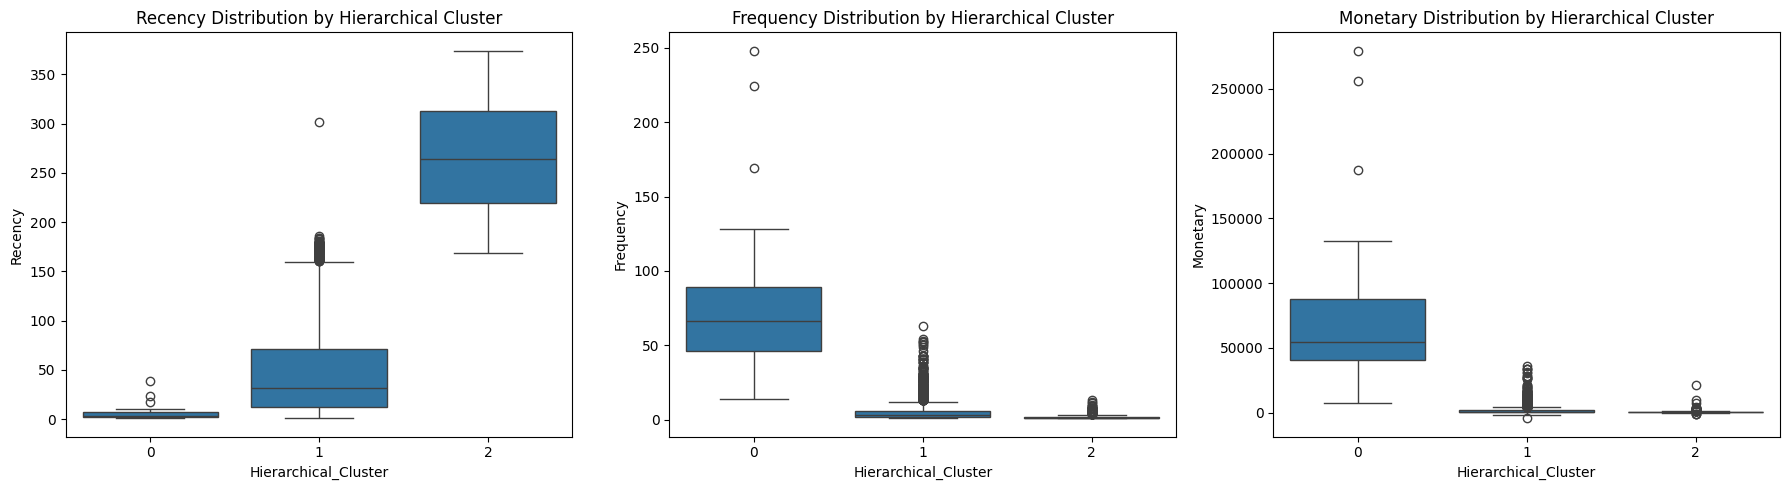

In [50]:
# Set up the figure size and layout for 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Recency distribution
sns.boxplot(x='Hierarchical_Cluster', y='Recency', data=rfm, ax=axes[0])
axes[0].set_title('Recency Distribution by Hierarchical Cluster')

# Plot Frequency distribution
sns.boxplot(x='Hierarchical_Cluster', y='Frequency', data=rfm, ax=axes[1])
axes[1].set_title('Frequency Distribution by Hierarchical Cluster')

# Plot Monetary distribution
sns.boxplot(x='Hierarchical_Cluster', y='Monetary', data=rfm, ax=axes[2])
axes[2].set_title('Monetary Distribution by Hierarchical Cluster')

plt.tight_layout()
plt.show()
